In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Tensorflow and Deep Learning

In this lab assignment, first you will learn how to build and train a neural network that recognises handwritten digits, and then you will build LeNet-5 CNN architecture, which is widely used for handwritten digit recognition. At the end of this lab assignment, you will make AlexNet CNN architecture, which won the 2012 ImageNet ILSVRC challenge.

---
# 1. Dataset
In the first part of the assignment, we use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. There are 70,000 images, and each image has 784 features. This is because each image is 28×28=784 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The following figure shows a few images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src="figs/1-mnist.png" style="width: 300px;"/>

To begin the assignment, first, use `mnist_data.read_data_sets` and download images and labels. It return two lists, called `mnist.test` with 10K images+labels, and `mnist.train` with 60K images+labels.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

In [4]:
mnist = mnist_data.read_data_sets("./MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


---
# 2. A One-Layer Neural Network
<img src="figs/2-comic1.png" style="width: 500px;"/>

Let's start by building a one-layer neural network. Handwritten digits in the MNIST dataset are 28x28 pixel greyscale images. The simplest approach for classifying them is to use the 28x28=784 pixels as inputs for a **one-layer neural network**. Each neuron in the network does a weighted sum of all of its inputs, adds a bias and then feeds the result through some non-linear activation function. Here we design a one-layer neural network with 10 output neurons since we want to classify digits into 10 classes (0 to 9).
<img src="figs/3-one_layer.png" style="width: 400px;"/>


For a classification problem, an *activation function* that works well is **softmax**. Applying softmax on a vector is done by taking the exponential of each element and then normalising the vector.
<img src="figs/4-softmax.png" style="width: 300px;"/>

We can summarise the behaviour of this single layer of neurons into a simple formula using a *matrix multiply*. If we give input data into the network in *mini-batch* of 100 images, it produces 100 predictions as the output. We define the **weights matrix $W$** with 10 columns, in which each column indicates the weight of a one class (a single digit), from 0 to 9. Using the first column of $W$, we can compute the weighted sum of all the pixels of the first image. This sum corresponds to the first neuron that points to the number 0. Using the second column of $W$, we do the same for the second neuron (number 1) and so on until the 10th neuron. We can then repeat the operation for the remaining 99 images in the mini-batch. If we call $X$ the matrix containing our 100 images (each row corresponds to one digit), all the weighted sums for our 10 neurons, computed on 100 images are simply $X.W$. Each neuron must now add its bias. Since we have 10 neurons, we have 10 bias constants. We finally apply the **softmax activation function** and obtain the formula describing a one-layer neural network, applied to 100 images.
<img src="figs/5-xw.png" style="width: 600px;"/>
<img src="figs/6-softmax2.png" style="width: 500px;"/>

Then, we need to use the **cross-entropy** to measure how good the predictions are, i.e., the distance between what the network tells us and what we know to be the truth. The cross-entropy is a function of weights, biases, pixels of the training image and its known label. If we compute the partial derivatives of the cross-entropy relatively to all the weights and all the biases, we obtain a **gradient**, computed for a given image, label and present value of weights and biases. We can update weights and biases by a fraction of the gradient and do the same thing again using the next batch of training images.
<img src="figs/7-cross_entropy.png" style="width: 600px;"/>

### Define Variables and Placeholders
First we define TensorFlow **variables** and **placeholders**. *Variables* are all the parameters that you want the training algorithm to determine for you (e.g., weights and biases). *Placeholders* are parameters that will be filled with actual data during training (e.g., training images). The shape of the tensor holding the training images is [None, 28, 28, 1] which stands for:
  - 28, 28, 1: our images are 28x28 (784) pixels x 1 value per pixel (grayscale). The last number would be 3 for color images and is not really necessary here.
  - None: this dimension will be the number of images in the mini-batch. It will be known at training time.

We also need an additional placeholder for the training labels that will be provided alongside training images.

In [5]:
# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y_hat [batch, 10]

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28 * 28 * 1])

# correct answers will go here
Y = tf.placeholder(tf.float32, [None, 10])

In [6]:
# weights W[784, 10], 784 = 28 * 28
W = tf.get_variable(
    "the_weights", dtype=tf.float32, initializer=tf.zeros((28 * 28, 10))
)

# biases b[10]
b = tf.get_variable("the_bias", dtype=tf.float32, initializer=tf.zeros((10)))

### Build The Model
Now, we can make a **model** for a one-layer neural network. The formula is the one we explained before, i.e., $\hat{Y} = softmax(X . W + b)$. You can use the `tf.nn.softmax` and `tf.matmul` to build the model. Here, we need to use the `tf.reshape` to transform our 28x28 images into single vectors of 784 pixels.

In [7]:
# flatten the images into a single line of pixels
# XX = tf.reshape(X,[-1,28*28*1])

# The model
Y_hat = tf.nn.softmax(tf.matmul(X, W) + b)

### Define The Cost Function
Now, we have model predictions $\hat{Y}$ and correct labels $Y$, so for each instance $i$ (image) we can compute the cross-entropy as the **cost function**: $cross\_entropy = -\sum(Y_i * log(\hat{Y}i))$. You can use `reduce_mean` to add all the components in a tensor.

In [13]:
cross_entropy = tf.reduce_mean(-Y * tf.log(Y_hat))  # element-wise multiplication

### Traine the Model
Now, select the gradient descent optimiser `GradientDescentOptimizer` and ask it to minimise the cross-entropy cost. In this step, TensorFlow computes the partial derivatives of the cost function relatively to all the weights and all the biases (the gradient). The gradient is then used to update the weights and biases. Set the learning rate is $0.005$.

In [14]:
optimizer = tf.train.GradientDescentOptimizer(0.005)
train_step = optimizer.minimize(cross_entropy)

### Execute the Model
It is time to run the training loop. All the TensorFlow instructions up to this point have been preparing a computation graph in memory but nothing has been computed yet. The computation requires actual data to be fed into the placeholders. This is supplied in the form of a Python dictionary, where the keys are the names of the placeholders. During the trainig print out the cost every 200 steps. Moreove, after training the model, print out the accurray of the model by testing it on the test data.

In [15]:
# init
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    init.run()
    input_images, correct_predictions = mnist.train.next_batch(100)
    loss = 0
    res = sess.run(cross_entropy, feed_dict={X: input_images, Y: correct_predictions})
    print(res)


#     for epoch in range(n_epochs):
#         input_images, correct_predictions = mnist.train.next_batch(100)

#         train_accuracy = sess.run(train_step, feed_dict={X: input_images, Y: correct_predictions})
#         if epoch % 100 == 0:
#             print("{} - train cost: {}".format(epoch, train_accuracy))

# # test accuracy
#     test_accuracy = sess.run(train_step, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
#     print("Final test accuracy: {}".format(test_accuracy))

0.23025854


In [16]:
# init
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        input_images, correct_predictions = mnist.train.next_batch(100)

        _, train_accuracy = sess.run(
            [train_step, cross_entropy],
            feed_dict={X: input_images, Y: correct_predictions},
        )
        if epoch % 100 == 0:
            print("{} - train cost: {}".format(epoch, train_accuracy))

    # test accuracy
    test_accuracy = sess.run(
        cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}
    )
    print()
    print("Final test accuracy: {}".format(test_accuracy))

0 - train cost: 0.2302585393190384
100 - train cost: 0.23026156425476074
200 - train cost: 0.23021571338176727
300 - train cost: 0.23028264939785004
400 - train cost: 0.23019076883792877
500 - train cost: 0.23013891279697418
600 - train cost: 0.230149045586586
700 - train cost: 0.23005904257297516
800 - train cost: 0.2304256558418274
900 - train cost: 0.23034682869911194
1000 - train cost: 0.2301911562681198
1100 - train cost: 0.2304680198431015
1200 - train cost: 0.23017805814743042
1300 - train cost: 0.23050127923488617
1400 - train cost: 0.23061464726924896
1500 - train cost: 0.23017826676368713
1600 - train cost: 0.2305244654417038
1700 - train cost: 0.22960519790649414
1800 - train cost: 0.23029831051826477
1900 - train cost: 0.2299644947052002
2000 - train cost: 0.22972750663757324
2100 - train cost: 0.22972650825977325
2200 - train cost: 0.23038655519485474
2300 - train cost: 0.22988131642341614
2400 - train cost: 0.22987790405750275
2500 - train cost: 0.2304135113954544
2600 - 

---
# 3. Add More Layers

<img src="figs/8-comic2.png" style="width: 500px;"/>

Now, let's improve the recognition accuracy by adding more layers to the neural network. The neurons in the second layer, instead of computing weighted sums of pixels will compute weighted sums of neuron outputs from the previous layer. We keep the softmax function as the activation function on the last layer, but on intermediate layers we will use the the **sigmoid** activation function. So, let's build a five-layer fully connected neural network with the following structure, and train the model with the trainging data and print out its accuracy on the test data.
<img src="figs/9-five_layer.png" style="width: 500px;"/>

In [17]:
# neural network with five layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1 [200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2 [100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3 [60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4 [30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5 [10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 28 * 28 * 1])  # Already flat
Y = tf.placeholder(tf.float32, shape=[None, 10])  # Already one hot

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
W1 = tf.get_variable("W1", dtype=tf.float32, initializer=tf.zeros((28 * 28, 200)))
B1 = tf.get_variable("B1", dtype=tf.float32, initializer=tf.zeros((200)))

W2 = tf.get_variable("W2", dtype=tf.float32, initializer=tf.zeros((200, 100)))
B2 = tf.get_variable("B2", dtype=tf.float32, initializer=tf.zeros((100)))

W3 = tf.get_variable("W3", dtype=tf.float32, initializer=tf.zeros((100, 60)))
B3 = tf.get_variable("B3", dtype=tf.float32, initializer=tf.zeros((60)))

W4 = tf.get_variable("W4", dtype=tf.float32, initializer=tf.zeros((60, 30)))
B4 = tf.get_variable("B4", dtype=tf.float32, initializer=tf.zeros((30)))

W5 = tf.get_variable("W5", dtype=tf.float32, initializer=tf.zeros((30, 10)))
B5 = tf.get_variable("B5", dtype=tf.float32, initializer=tf.zeros((10)))

########################################
# build the model
########################################
# XX = tf.reshape<FILL IN>

Y1_hat = tf.nn.sigmoid(tf.matmul(X, W1) + B1)
Y2_hat = tf.nn.sigmoid(tf.matmul(Y1_hat, W2) + B2)
Y3_hat = tf.nn.sigmoid(tf.matmul(Y2_hat, W3) + B3)
Y4_hat = tf.nn.sigmoid(tf.matmul(Y3_hat, W4) + B4)
Y_hat = tf.nn.softmax(tf.matmul(Y4_hat, W5) + B5)

########################################
# define the cost function
########################################
cross_entropy = tf.reduce_mean(-Y * tf.log(Y_hat))  # element-wise multiplication

########################################
# define the optimizer
########################################
optimizer = tf.train.GradientDescentOptimizer(0.005)
train_step = optimizer.minimize(cross_entropy)

In [18]:
########################################
# execute the model
########################################
# init
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # input_images, correct_predictions = mnist.train.images, mnist.train.labels
        input_images, correct_predictions = mnist.train.next_batch(500)

        _, train_accuracy = sess.run(
            [train_step, cross_entropy],
            feed_dict={X: input_images, Y: correct_predictions},
        )
        if epoch % 100 == 0:
            print("{} - train cost: {}".format(epoch, train_accuracy))

    # test accuracy
    test_accuracy = sess.run(
        cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}
    )
    print()
    print("Final test accuracy: {}".format(test_accuracy))

0 - train cost: 0.23025834560394287
100 - train cost: 0.23024746775627136
200 - train cost: 0.23026078939437866
300 - train cost: 0.23023314774036407
400 - train cost: 0.2301780730485916
500 - train cost: 0.23021867871284485
600 - train cost: 0.2302878350019455
700 - train cost: 0.23017680644989014
800 - train cost: 0.23016196489334106
900 - train cost: 0.2301091104745865
1000 - train cost: 0.23017846047878265
1100 - train cost: 0.23008482158184052
1200 - train cost: 0.23016846179962158
1300 - train cost: 0.230192169547081
1400 - train cost: 0.2301531285047531
1500 - train cost: 0.23016518354415894
1600 - train cost: 0.23031142354011536
1700 - train cost: 0.23019707202911377
1800 - train cost: 0.2302347719669342
1900 - train cost: 0.23025746643543243
2000 - train cost: 0.23021410405635834
2100 - train cost: 0.22994384169578552
2200 - train cost: 0.2301223874092102
2300 - train cost: 0.23036950826644897
2400 - train cost: 0.23011566698551178
2500 - train cost: 0.23037080466747284
2600 -

---
# 4. Special Care for Deep Networks
As layers were added, neural networks tended to converge with more difficulties. For example, the accuracy could stuck at 0.1. Here, we want to apply some updates to the network we built in the previous part to improve its performance. 

### ReLU Activation Function
<img src="figs/10-comic3.png" style="width: 500px;"/>
The sigmoid activation function is actually quite problematic in deep networks. It squashes all values between 0 and 1 and when you do so repeatedly, neuron outputs and their gradients can vanish entirely. An alternative activation function is **ReLU** that shows better performance compare to sigmoid. It looks like as below:
<img src="figs/11-relu.png" style="width: 300px;"/>

### A Better Optimizer
In very high dimensional spaces like here, **saddle points** are frequent. These are points that are not local minima, but where the gradient is nevertheless zero and the gradient descent optimizer stays stuck there. One possible solution to tackle this probelm is to use better optimizers, such as Adam optimizer `tf.train.AdamOptimizer`.

### Random Initialisations
When working with ReLUs, the best practice is to initialise bias values to small positive values, so that neurons operate in the non-zero range of the ReLU initially.

### Learning Rate
<img src="figs/12-comic4.png" style="width: 500px;"/>
With two, three or four intermediate layers, you can now get close to 98% accuracy, if you push the iterations to 5000 or beyond. But, the results are not very consistent, and the curves jump up and down by a whole percent. A good solution is to start fast and decay the learning rate exponentially from $0.005$ to $0.0001$ for example. In order to pass a different learning rate to the `AdamOptimizer` at each iteration, you will need to define a new placeholder and feed it a new value at each iteration through `feed_dict`. Here is the formula for exponential decay: $learning\_rate = lr\_min + (lr\_max - lr\_min) * e^{\frac{-i}{2000}}$, where $i$ is the iteration number.

### NaN?
In the network you built in the last section, you might see accuracy curve crashes and the console outputs NaN for the cross-entropy. It may happen, because you are attempting to compute a $log(0)$, which is indeed Not A Number (NaN). Remember that the cross-entropy involves a log, computed on the output of the softmax layer. Since softmax is essentially an exponential, which is never zero, we should be fine, but with 32 bit precision floating-point operations, exp(-100) is already a genuine zero. TensorFlow has a handy function that computes the softmax and the cross-entropy in a single step, implemented in a numerically stable way. To use it, you will need to separate the weighted sum plus bias on the last layer, before softmax is applied and then give it with the true values to the function `tf.nn.softmax_cross_entropy_with_logits`.

In the code below, apply the following changes and show their impact on the accuracy of the model on training data, as well as the test data:
* Replace the sigmoid activation function with ReLU
* Use the Adam optimizer
* Initialize weights with small random values between -0.2 and +0.2, and make sure biases are initialised with small positive values, for example 0.1
* Update the learning rate in different iterations. Start fast and decay the learning rate exponentially from $0.005$ to $0.0001$, i.e., 
```
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
```
* Use `tf.nn.softmax_cross_entropy_with_logits` to prevent getting NaN in output.

In [19]:
# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 28 * 28 * 1])  # Already flat
Y = tf.placeholder(tf.float32, shape=[None, 10])  # Already one hot

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
W1 = tf.get_variable("W1", dtype=tf.float32, shape=(28*28, 200), initializer=tf.initializers.random_uniform(-0.2,0.2))
B1 = tf.get_variable("B1", dtype=tf.float32, shape=(200), initializer=tf.initializers.random_uniform(0.09,0.11))

W2 = tf.get_variable("W2", dtype=tf.float32, shape=(200, 100), initializer=tf.initializers.random_uniform(-0.2,0.2))
B2 = tf.get_variable("B2", dtype=tf.float32, shape=(100), initializer=tf.initializers.random_uniform(0.09,0.11))

W3 = tf.get_variable("W3", dtype=tf.float32, shape=(100, 60), initializer=tf.initializers.random_uniform(-0.2,0.2))
B3 = tf.get_variable("B3", dtype=tf.float32, shape=(60), initializer=tf.initializers.random_uniform(0.09,0.11))

W4 = tf.get_variable("W4", dtype=tf.float32, shape=(60, 30), initializer=tf.initializers.random_uniform(-0.2,0.2))
B4 = tf.get_variable("B4", dtype=tf.float32, shape=(30), initializer=tf.initializers.random_uniform(0.09,0.11))

W5 = tf.get_variable("W5", dtype=tf.float32, shape=(30, 10), initializer=tf.initializers.random_uniform(-0.2,0.2))
B5 = tf.get_variable("B5", dtype=tf.float32, shape=(10), initializer=tf.initializers.random_uniform(0.09,0.11))

########################################
# build the model
########################################
# XX = tf.reshape<FILL IN>

Y1_hat = tf.nn.relu(tf.matmul(X, W1) + B1)
Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, W2) + B2)
Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, W3) + B3)
Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, W4) + B4)
Y_hat = (tf.matmul(Y4_hat, W5) + B5)  # the softmax is computed in the cross_entropy calculation. See: https://stackoverflow.com/a/34243720/2496574

########################################
# defining the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_hat, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optimizer
########################################
# learning_rate = tf.placeholder(dtype=tf.float32, shape=0)
learning_rate = tf.Variable(0.005, trainable=False, dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # default conf
train_step = optimizer.minimize(cross_entropy)

In [20]:
import math
def compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, iteration):
    return min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-iteration/decay_speed)

In [21]:
########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
#         input_images, correct_predictions = mnist.train.images, mnist.train.labels
        if epoch % 2000 == 0:
            new_lr = compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, epoch)
            print("Updating learning rate to {}".format(new_lr))
            assign_op = learning_rate.assign(new_lr)
            sess.run(assign_op)
            
        input_images, correct_predictions = mnist.train.next_batch(500)

        _,train_accuracy = sess.run([train_step,cross_entropy], feed_dict={X: input_images, Y: correct_predictions})
        if epoch % 100 == 0:
            print("{} - train cost: {}".format(epoch, train_accuracy))
        # test accuracy
            test_accuracy = sess.run(cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
            print("{} -  test cost: {}".format(epoch, test_accuracy))
            print()

Updating learning rate to 0.005
0 - train cost: 238.07699584960938
0 -  test cost: 213.5122528076172

100 - train cost: 17.33509635925293
100 -  test cost: 15.415312767028809

200 - train cost: 9.915480613708496
200 -  test cost: 11.441130638122559

300 - train cost: 4.355239391326904
300 -  test cost: 10.746392250061035

400 - train cost: 3.488163948059082
400 -  test cost: 8.69344711303711

500 - train cost: 2.230314016342163
500 -  test cost: 9.403192520141602

600 - train cost: 4.010378837585449
600 -  test cost: 8.938048362731934

700 - train cost: 4.507970333099365
700 -  test cost: 9.542865753173828

800 - train cost: 2.4812333583831787
800 -  test cost: 10.220025062561035

900 - train cost: 2.4344122409820557
900 -  test cost: 9.778674125671387

1000 - train cost: 2.7470014095306396
1000 -  test cost: 8.705485343933105

1100 - train cost: 3.753953695297241
1100 -  test cost: 10.893986701965332

1200 - train cost: 1.0862654447555542
1200 -  test cost: 11.899270057678223

1300 - 

Wiiiii Overfitting!

---
# 5. Overfitting and Dropout
<img src="figs/13-comic5.png" style="width: 500px;"/>
You will have noticed that cross-entropy curves for test and training data start disconnecting after a couple thousand iterations. The learning algorithm works on training data only and optimises the training cross-entropy accordingly. It never sees test data so it is not surprising that after a while its work no longer has an effect on the test cross-entropy which stops dropping and sometimes even bounces back up. 
<img src="figs/14-overfit.png" style="width: 500px;"/>
This disconnect is usually labeled **overfitting** and when you see it, you can try to apply a regularisation technique called **dropout**. In dropout, at each training iteration, you drop random neurons from the network. You choose a probability `pkeep` for a neuron to be kept, usually between 50% and 75%, and then at each iteration of the training loop, you randomly remove neurons with all their weights and biases. Different neurons will be dropped at each iteration. When testing the performance of your network of course you put all the neurons back (`pkeep = 1`).
<img src="figs/15-dropout.png" style="width: 500px;"/>
TensorFlow offers a dropout function to be used on the outputs of a layer of neurons. It randomly zeroes-out some of the outputs and boosts the remaining ones by `1 / pkeep`. You can add dropout after each intermediate layer in the network now. 

In the following code, use the dropout between each layer during the training, and set the probability `pkeep` once to $50%$ and another time to $75%$ and compare their results.

In [22]:
# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None,28*28*1]) # Already flat
Y = tf.placeholder(tf.float32, shape=[None,10]) # Already one hot

# probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1


# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
W1 = tf.get_variable("W1", dtype=tf.float32, shape=(28*28, 200), initializer=tf.initializers.random_uniform(-0.2,0.2))
B1 = tf.get_variable("B1", dtype=tf.float32, shape=(200), initializer=tf.initializers.random_uniform(0.09,0.11))

W2 = tf.get_variable("W2", dtype=tf.float32, shape=(200, 100), initializer=tf.initializers.random_uniform(-0.2,0.2))
B2 = tf.get_variable("B2", dtype=tf.float32, shape=(100), initializer=tf.initializers.random_uniform(0.09,0.11))

W3 = tf.get_variable("W3", dtype=tf.float32, shape=(100, 60), initializer=tf.initializers.random_uniform(-0.2,0.2))
B3 = tf.get_variable("B3", dtype=tf.float32, shape=(60), initializer=tf.initializers.random_uniform(0.09,0.11))

W4 = tf.get_variable("W4", dtype=tf.float32, shape=(60, 30), initializer=tf.initializers.random_uniform(-0.2,0.2))
B4 = tf.get_variable("B4", dtype=tf.float32, shape=(30), initializer=tf.initializers.random_uniform(0.09,0.11))

W5 = tf.get_variable("W5", dtype=tf.float32, shape=(30, 10), initializer=tf.initializers.random_uniform(-0.2,0.2))
B5 = tf.get_variable("B5", dtype=tf.float32, shape=(10), initializer=tf.initializers.random_uniform(0.09,0.11))

########################################
# build the model
########################################


Y1_hat = tf.nn.relu(tf.matmul(X,W1) + B1)
Y1_hat_dropout = tf.nn.dropout(Y1_hat, pkeep)

Y2_hat = tf.nn.relu(tf.matmul(Y1_hat_dropout,W2) + B2)
Y2_hat_dropout = tf.nn.dropout(Y2_hat, pkeep)

Y3_hat = tf.nn.relu(tf.matmul(Y2_hat_dropout,W3) + B3)
Y3_hat_dropout = tf.nn.dropout(Y3_hat, pkeep)

Y4_hat = tf.nn.relu(tf.matmul(Y3_hat_dropout,W4) + B4)
Y4_hat_dropout = tf.nn.dropout(Y4_hat, pkeep)

Y_hat = tf.matmul(Y4_hat_dropout,W5) + B5  # the softmax is computed in the cross_entropy calculation. See: https://stackoverflow.com/a/34243720/2496574

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=Y_hat,
    labels=Y
)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optimizer
########################################
learning_rate = tf.Variable(0.005, trainable=False, dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # default conf
train_step = optimizer.minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

for pkeep_val in [0.5, 0.7]:

    with tf.Session() as sess:
        init.run()

        for epoch in range(n_epochs):
    #         input_images, correct_predictions = mnist.train.images, mnist.train.labels
            if epoch % 2000 == 0:
                new_lr = compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, epoch)
                print("Updating learning rate to {}".format(new_lr))
                assign_op = learning_rate.assign(new_lr)
                sess.run(assign_op)

            input_images, correct_predictions = mnist.train.next_batch(500)

            _,train_accuracy = sess.run([train_step,cross_entropy], feed_dict={X: input_images, Y: correct_predictions, pkeep: pkeep_val})
            if epoch % 100 == 0:
                print("{} - train cost: {}".format(epoch, train_accuracy))
                # test accuracy
                test_accuracy = sess.run(cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, pkeep: 1})
                print("{} -  test cost: {}".format(epoch, test_accuracy))
                print()

Updating learning rate to 0.005
0 - train cost: 296.2811279296875
0 -  test cost: 229.7067413330078

100 - train cost: 97.69552612304688
100 -  test cost: 65.36514282226562

200 - train cost: 63.962913513183594
200 -  test cost: 35.341064453125

300 - train cost: 57.32229232788086
300 -  test cost: 25.507408142089844

400 - train cost: 53.63157272338867
400 -  test cost: 23.572866439819336

500 - train cost: 38.461788177490234
500 -  test cost: 21.002180099487305

600 - train cost: 48.33771896362305
600 -  test cost: 19.602684020996094

700 - train cost: 39.57976150512695
700 -  test cost: 19.530920028686523

800 - train cost: 52.11991500854492
800 -  test cost: 18.169347763061523

900 - train cost: 39.24048614501953
900 -  test cost: 18.47260856628418

1000 - train cost: 39.31443405151367
1000 -  test cost: 17.345989227294922

1100 - train cost: 24.720584869384766
1100 -  test cost: 17.365739822387695

1200 - train cost: 32.727779388427734
1200 -  test cost: 17.269866943359375

1300 -

Dropout at 0.7 and early stopping may achieve the better result with a test cost around 10

---
# 6. Convolutional Network
<img src="figs/16-comic6.png" style="width: 500px;"/>
In the previous sections, all pixels of images flattened into a single vector, which was a really bad idea. Handwritten digits are made of shapes and we discarded the shape information when we flattened the pixels. However, we can use **convolutional neural networks (CNN)** to take advantage of shape information. CNNs apply *a series of filters* to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:
  - **Convolutional layers**: apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.
  - **Pooling layers**: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.
  - **Dense (fully connected) layers**: perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.
  
Typically, a CNN is composed of a *stack of **convolutional modules*** that perform feature extraction. Each *module* consists of a *convolutional layer* followed by a *pooling layer*. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single neuron for each target class in the model, with a softmax activation function to generate a value between 0-1 for each neuron. We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.

Now, let us build a convolutional network for handwritten digit recognition. In this assignment, we will use the architecture shown in the following figure that has three convolutional layers, one fully-connected layer, and one softmax layer. Notice that the second and third convolutional layers have a stride of two that explains why they bring the number of output values down from 28x28 to 14x14 and then 7x7. A convolutional layer requires a weights tensor like `[4, 4, 3, 2]`, in which the first two numbers define the size of a filter (map), the third number shows the *depth* of the filter that is the number of *input channel*, and the last number shows the number of *output channel*. The output channel defines the number of times that we repeat the same thing with a different set of weights in one layer. In our implementation, we assume the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected layer is 200.
<img src="figs/17-arch1.png" style="width: 600px;"/>

Convolutional layers can be implemented in TensorFlow using the `tf.nn.conv2d` function, which performs the scanning of the input image in both directions using the supplied weights. This is only the weighted sum part of the neuron. You still need to add a bias and feed the result through an activation function. The padding strategy that works here is to copy pixels from the sides of the image. All digits are on a uniform background so this just extends the background and should not add any unwanted shapes.

In [24]:
# Need to redifine mnsit without reshape otherwise the convolution has no sens
mnist = mnist_data.read_data_sets("./MNIST_data/", one_hot=True, reshape=False)
mnist.train.images.shape

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 28, 28, 1)

In [25]:
# · · · · · · · · · ·      (input data, 1-deep)               X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 5x5x1=>4 stride 1      W1 [5, 5, 1, 4]        B1 [4]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 4]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x4=>8 stride 2      W2 [5, 5, 4, 8]        B2 [8]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 8]
#     @ @ @ @ @ @       -- conv. layer 4x4x8=>12 stride 2     W3 [4, 4, 8, 12]       B3 [12]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 12] => reshaped to YY [batch, 7*7*12]
#      \x/x\x\x/        -- fully connected layer (relu)       W4 [7*7*12, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)    W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None,28,28,1]) # Already flat
Y = tf.placeholder(tf.float32, shape=[None,10]) # Already one hot

# trying with placeholder
learning_rate_pl = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200
W1 = tf.get_variable("W1", dtype=tf.float32, shape=(5, 5, 1, 4), initializer=tf.initializers.random_uniform(-0.2,0.2))
B1 = tf.get_variable("B1", dtype=tf.float32, shape=(4), initializer=tf.initializers.random_uniform(0.09,0.11))  # one bias per filter

W2 = tf.get_variable("W2", dtype=tf.float32, shape=(5, 5, 4, 8), initializer=tf.initializers.random_uniform(-0.2,0.2))
B2 = tf.get_variable("B2", dtype=tf.float32, shape=(8), initializer=tf.initializers.random_uniform(0.09,0.11))

W3 = tf.get_variable("W3", dtype=tf.float32, shape=(4, 4, 8, 12), initializer=tf.initializers.random_uniform(-0.2,0.2))
B3 = tf.get_variable("B3", dtype=tf.float32, shape=(12), initializer=tf.initializers.random_uniform(0.09,0.11))

# dense layers

W4 = tf.get_variable("W4", dtype=tf.float32, shape=(7 * 7 * 12, 200), initializer=tf.initializers.random_uniform(-0.2,0.2))
B4 = tf.get_variable("B4", dtype=tf.float32, shape=(200), initializer=tf.initializers.random_uniform(0.09,0.11))

W5 = tf.get_variable("W5", dtype=tf.float32, shape=(200, 10), initializer=tf.initializers.random_uniform(-0.2,0.2))
B5 = tf.get_variable("B5", dtype=tf.float32, shape=(10), initializer=tf.initializers.random_uniform(0.09,0.11))

########################################
# build the model
########################################
# the stride is on the input, input tensor is: [n_instances, w, h, c]
# So the stride has to affect only w,h (in this case)
stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, [ -1,  7 * 7 * 12 ])  # -1 stretches the dimension to keep the other one costant. I guess is the dimension of the instances
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
Y_hat = tf.matmul(Y4_hat, W5) + B5

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits = Y_hat,
    labels = Y
)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optmizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)  # default conf
train_step = optimizer.minimize(cross_entropy)

In [26]:
########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

learning_rate = max_learning_rate
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         input_images, correct_predictions = mnist.train.images, mnist.train.labels
        if epoch % 2000 == 0:
            learning_rate = compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, epoch)
            print("Updating learning rate to {}".format(learning_rate))

        input_images, correct_predictions = mnist.train.next_batch(100)

        _,train_accuracy = sess.run([train_step,cross_entropy], feed_dict={X: input_images, Y: correct_predictions, learning_rate_pl: learning_rate})
        if epoch % 100 == 0:
            print("{} - train loss: {}".format(epoch, train_accuracy))
            # test accuracy
            test_accuracy = sess.run(cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
            print("{} -  test loss: {}".format(epoch, test_accuracy))
            print()

Updating learning rate to 0.005
0 - train loss: 259.9378356933594
0 -  test loss: 250.52989196777344

100 - train loss: 19.27527618408203
100 -  test loss: 16.182504653930664

200 - train loss: 16.405517578125
200 -  test loss: 13.189262390136719

300 - train loss: 11.755677223205566
300 -  test loss: 8.945940971374512

400 - train loss: 7.1562371253967285
400 -  test loss: 7.935722827911377

500 - train loss: 7.299345970153809
500 -  test loss: 10.00326919555664

600 - train loss: 3.473390579223633
600 -  test loss: 5.956932544708252

700 - train loss: 0.6059093475341797
700 -  test loss: 7.112620830535889

800 - train loss: 9.263669967651367
800 -  test loss: 6.038978576660156

900 - train loss: 17.780689239501953
900 -  test loss: 5.6301398277282715

1000 - train loss: 17.980318069458008
1000 -  test loss: 6.292648792266846

1100 - train loss: 0.9063008427619934
1100 -  test loss: 6.14439582824707

1200 - train loss: 3.2732255458831787
1200 -  test loss: 5.147933006286621

1300 - tr

# 7. Improve The Performance
A good approach to sizing your neural networks is to implement a network that is a little too constrained, then give it a bit more degrees of freedom and add dropout to make sure it is not overfitting. This ends up with a fairly optimal network for your problem. In the above model, we set the output channel to 4 in the first convolutional layer, which means that we repeat the same filter shape (but with different weights) four times. If we assume that those filters evolve during training into shape recognisers, you can intuitively see that this might not be enough for our problem. Handwritten digits are made from more than 4 elemental shapes. So let us bump up the filter sizes a little, and also increase the number of filters in our convolutional layers from 4, 8, 12 to 6, 12, 24 and then add dropout on the fully-connected layer. The following figure shows the new architecture you should build. Please complete the following code based on the given architecture and dropout technique.
<img src="figs/18-arch2.png" style="width: 600px;"/>

In [27]:
# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None,28,28,1]) # Already flat
Y = tf.placeholder(tf.float32, shape=[None,10]) # Already one hot
pkeep = tf.placeholder(tf.float32)

# trying with placeholder
learning_rate_pl = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200
W1 = tf.get_variable("W1", dtype=tf.float32, shape=(6, 6, 1, 6), initializer=tf.initializers.random_uniform(-0.2,0.2))
B1 = tf.get_variable("B1", dtype=tf.float32, shape=(6), initializer=tf.initializers.random_uniform(0.09,0.11))  # one bias per filter

W2 = tf.get_variable("W2", dtype=tf.float32, shape=(5, 5, 6, 12), initializer=tf.initializers.random_uniform(-0.2,0.2))
B2 = tf.get_variable("B2", dtype=tf.float32, shape=(12), initializer=tf.initializers.random_uniform(0.09,0.11))

W3 = tf.get_variable("W3", dtype=tf.float32, shape=(4, 4, 12, 24), initializer=tf.initializers.random_uniform(-0.2,0.2))
B3 = tf.get_variable("B3", dtype=tf.float32, shape=(24), initializer=tf.initializers.random_uniform(0.09,0.11))

# dense layers

W4 = tf.get_variable("W4", dtype=tf.float32, shape=(7 * 7 * 24, 200), initializer=tf.initializers.random_uniform(-0.2,0.2))
B4 = tf.get_variable("B4", dtype=tf.float32, shape=(200), initializer=tf.initializers.random_uniform(0.09,0.11))

W5 = tf.get_variable("W5", dtype=tf.float32, shape=(200, 10), initializer=tf.initializers.random_uniform(-0.2,0.2))
B5 = tf.get_variable("B5", dtype=tf.float32, shape=(10), initializer=tf.initializers.random_uniform(0.09,0.11))


########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, shape=[-1, 7 * 7 * 24])
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
YY4_hat = tf.nn.dropout(Y4_hat, pkeep)
Y_hat = tf.matmul(YY4_hat, W5) + B5

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits = Y_hat,
    labels = Y
)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# train the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)  # default conf
train_step = optimizer.minimize(cross_entropy)

In [28]:
########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

learning_rate = max_learning_rate
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         input_images, correct_predictions = mnist.train.images, mnist.train.labels
        if epoch % 2000 == 0:
            learning_rate = compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, epoch)
            print("Updating learning rate to {}".format(learning_rate))

        input_images, correct_predictions = mnist.train.next_batch(100)

        _,train_accuracy = sess.run([train_step,cross_entropy], feed_dict={X: input_images, Y: correct_predictions, learning_rate_pl: learning_rate, pkeep: 0.75})
        if epoch % 100 == 0:
            print("{} - train loss: {}".format(epoch, train_accuracy))
            # test accuracy
            test_accuracy = sess.run(cross_entropy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, pkeep: 1})
            print("{} -  test loss: {}".format(epoch, test_accuracy))
            print()

Updating learning rate to 0.005
0 - train loss: 357.5565490722656
0 -  test loss: 276.2358093261719

100 - train loss: 32.03110885620117
100 -  test loss: 12.803872108459473

200 - train loss: 17.570066452026367
200 -  test loss: 8.9464111328125

300 - train loss: 9.316620826721191
300 -  test loss: 7.615187168121338

400 - train loss: 6.138249397277832
400 -  test loss: 6.615544319152832

500 - train loss: 5.493896484375
500 -  test loss: 6.081175327301025

600 - train loss: 8.681408882141113
600 -  test loss: 7.16693115234375

700 - train loss: 6.743307590484619
700 -  test loss: 5.489811897277832

800 - train loss: 2.8938956260681152
800 -  test loss: 7.579813003540039

900 - train loss: 1.708518385887146
900 -  test loss: 5.057649612426758

1000 - train loss: 3.3875043392181396
1000 -  test loss: 5.074157238006592

1100 - train loss: 6.8910813331604
1100 -  test loss: 5.380756855010986

1200 - train loss: 7.418605804443359
1200 -  test loss: 5.203502178192139

1300 - train loss: 4.

---
# 8. Tensorflow Layers Module
The TensorFlow **layers** `tf.layers` module provides a high-level API that makes it easy to construct a neural network. It provides methods that facilitate: (i) the creation of dense (fully connected) layers and convolutional layers, (ii) adding activation functions, and (iii) applying dropout regularization. In this section use the module `tf.layers` to build the network you made in section 7.

In [29]:
# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph

# to reset the Tensorflow default graph
reset_graph()


# we can use the same input strategy

X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="X")  # Already flat
Y = tf.placeholder(tf.int32, shape=[None, 10], name="Y")  # Already one hot

conv1 = tf.layers.conv2d(
    inputs=X,
    filters=6,
    kernel_size=(6, 6),
    strides=(1, 1),
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

conv2 = tf.layers.conv2d(
    inputs=conv1,
    filters=12,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

conv3 = tf.layers.conv2d(
    inputs=conv2,
    filters=24,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

conv3_flat = tf.reshape(conv3, shape=[-1, 7 * 7 * 24])

dense1 = tf.layers.dense(
    inputs=conv3_flat,
    units=200,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

is_training = tf.placeholder(dtype=tf.bool)
pkeep = tf.placeholder(dtype=tf.float32)

dropout1 = tf.layers.dropout(inputs=dense1, rate=pkeep, training=is_training)

Y_logits = tf.layers.dense(
    inputs=dropout1,
    units=10,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
    #     activation=tf.identity
)

loss = tf.losses.softmax_cross_entropy(Y, Y_logits, reduction=tf.losses.Reduction.MEAN)

loss = loss * 100

learning_rate_pl = tf.placeholder(tf.float32)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)

train_op = optimizer.minimize(loss)

In [30]:
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        if epoch % 2000 == 0:
            learning_rate = compute_learning_rate(max_learning_rate, min_learning_rate, decay_speed, epoch)
            print("Updating learning rate to {}".format(learning_rate))

        input_images, correct_predictions = mnist.train.next_batch(100)

        _, train_loss = sess.run([train_op, loss], feed_dict={X: input_images, Y: correct_predictions, learning_rate_pl: 0.001, pkeep: 0.75, is_training: True} )
        if epoch % 100 == 0:
            print("{} - train loss: {}".format(epoch, train_loss))
            # test accuracy
            test_loss = sess.run(loss, feed_dict={X: mnist.test.images, Y: mnist.test.labels, pkeep: 1, is_training: False})
            print("{} -  test loss: {}".format(epoch, test_loss))
            print()

Updating learning rate to 0.005
0 - train loss: 477.540771484375
0 -  test loss: 240.97019958496094

100 - train loss: 67.48490905761719
100 -  test loss: 47.31666946411133

200 - train loss: 75.0513916015625
200 -  test loss: 26.488061904907227

300 - train loss: 38.21251678466797
300 -  test loss: 19.778242111206055

400 - train loss: 29.814239501953125
400 -  test loss: 16.1962947845459

500 - train loss: 54.767845153808594
500 -  test loss: 15.159114837646484

600 - train loss: 23.563322067260742
600 -  test loss: 12.084699630737305

700 - train loss: 27.320436477661133
700 -  test loss: 11.67176342010498

800 - train loss: 15.03106689453125
800 -  test loss: 10.29846477508545

900 - train loss: 22.53934097290039
900 -  test loss: 9.124110221862793

1000 - train loss: 17.374040603637695
1000 -  test loss: 8.544035911560059

1100 - train loss: 21.61310386657715
1100 -  test loss: 8.569523811340332

1200 - train loss: 21.898679733276367
1200 -  test loss: 7.80363655090332

1300 - tra

---
# 9. Keras
Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production. `tf.keras` is TensorFlow's implementation of the Keras API specification. To work with Keras, you need to import `tf.keras` as part of your TensorFlow program setup.
```
import tensorflow as tf
from tensorflow.keras import layers
```
#### Build a model
In Keras, you assemble **layers** to build a model, i.e., a graph of layers. The most common type of model is a stack of layers: the `tf.keras.Sequential` model. For example, the following code builds a simple, fully-connected network (i.e., multi-layer perceptron):
```
model = tf.keras.Sequential()
# adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# add another
model.add(layers.Dense(64, activation='relu'))
# add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))
```
There are many `tf.keras.layers` available with some common constructor parameters:
* `activation`: set the activation function for the layer, which is specified by the name of a built-in function or as a callable object.
* `kernel_initializer` and `bias_initializer`: the initialization schemes that create the layer's weights (weight and bias).
* `kernel_regularizer` and `bias_regularizer`: the regularization schemes that apply the layer's weights (weight and bias), such as L1 or L2 regularization.

#### Train and evaluate
After you construct a model, you can configure its learning process by calling the `compile` method:
```
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```
The method `tf.keras.Model.compile` takes three important arguments:
* `optimizer`: it specifies the training procedure, e.g., `tf.train.AdamOptimizer` and `tf.train.GradientDescentOptimizer`.
* `loss`: the cost function to minimize during optimization, e.g., mean square error (mse), categorical_crossentropy, and binary_crossentropy.
* `metrics`: used to monitor training, e.g., `accuracy`.

The next step after confiuring the model is to train it by calling the `model.fit` method and giving it training data as its input. After training the model you can call `tf.keras.Model.evaluate` and `tf.keras.Model.predict` methods to evaluate the inference-mode loss and metrics for the data provided or predict the output of the last layer in inference for the data provided, respectively.

You can read more about Keras [here](https://www.tensorflow.org/guide/keras).

In this task, please use Keras to rebuild the network you made in section 7.

In [31]:
import keras

Using TensorFlow backend.


In [32]:
# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]


# to reset the Tensorflow default graph
reset_graph()

model = keras.Sequential()

model.add(
    keras.layers.Conv2D(
        6,
        (6, 6),
        strides=(1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=keras.initializers.RandomUniform(minval=-0.2, maxval=0.2),
        bias_initializer=keras.initializers.RandomUniform(minval=0.09, maxval=0.11),
        name="conv1",
    )
)

model.add(
    keras.layers.Conv2D(
        12,
        (5, 5),
        strides=(2, 2),
        padding="same",
        activation="relu",
        kernel_initializer=keras.initializers.RandomUniform(minval=-0.2, maxval=0.2),
        bias_initializer=keras.initializers.RandomUniform(minval=0.09, maxval=0.11),
        name="conv2",
    )
)

model.add(
    keras.layers.Conv2D(
        24,
        (4, 4),
        strides=(2, 2),
        padding="same",
        activation="relu",
        kernel_initializer=keras.initializers.RandomUniform(minval=-0.2, maxval=0.2),
        bias_initializer=keras.initializers.RandomUniform(minval=0.09, maxval=0.11),
        name="conv3",
    )
)

model.add(keras.layers.Flatten(name="flatten"))

model.add(
    keras.layers.Dense(
        200,
        activation="relu",
        kernel_initializer=keras.initializers.RandomUniform(minval=-0.2, maxval=0.2),
        bias_initializer=keras.initializers.RandomUniform(minval=0.09, maxval=0.11),
        name="dense1",
    )
)

model.add(keras.layers.Dropout(0.75))


model.add(
    keras.layers.Dense(
        10,
        activation="softmax",
        kernel_initializer=keras.initializers.RandomUniform(minval=-0.2, maxval=0.2),
        bias_initializer=keras.initializers.RandomUniform(minval=0.09, maxval=0.11),
        name="dense2",
    )
)


# max_learning_rate = 0.005
# min_learning_rate = 0.0001
# decay_speed = 2000.0
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

# decay = (max_learning_rate - min_learning_rate)decay_speed

optimizer = keras.optimizers.Adam(lr=0.005)

model.compile(
    optimizer,
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy],
)

In [33]:
# we have 55k training images, hence an epoch requires 550 batches of 100 instaces each
# before we were doing 5k batches which is close to nine epochs

model.fit(mnist.train.images, mnist.train.labels, batch_size=100, epochs=9)

Epoch 1/9
55000/55000 [==============================] - 30s 541us/step - loss: 0.3906 - categorical_accuracy: 0.8804
Epoch 2/9
55000/55000 [==============================] - 28s 516us/step - loss: 0.1504 - categorical_accuracy: 0.9564
Epoch 3/9
55000/55000 [==============================] - 29s 524us/step - loss: 0.1243 - categorical_accuracy: 0.9640
Epoch 4/9
55000/55000 [==============================] - 30s 553us/step - loss: 0.1156 - categorical_accuracy: 0.9666
Epoch 5/9
55000/55000 [==============================] - 31s 572us/step - loss: 0.1047 - categorical_accuracy: 0.9703
Epoch 6/9
55000/55000 [==============================] - 36s 657us/step - loss: 0.0997 - categorical_accuracy: 0.9715
Epoch 7/9
55000/55000 [==============================] - 41s 744us/step - loss: 0.0948 - categorical_accuracy: 0.9723
Epoch 8/9
55000/55000 [==============================] - 31s 565us/step - loss: 0.0955 - categorical_accuracy: 0.9738
Epoch 9/9
55000/55000 [==============================] -

---
# 10. Implement LeNet-5
In this section, you should implement **LeNet-5** either using Tensorflow or Keras. Please take a look at its [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) before starting to implement it.
The LeNet-5 architecture is perhaps the most widely known CNN architecture. It was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST). It is composed of the layers shown in the following table.
<img src="figs/19-letnet5.png" style="width: 600px;"/>
There are a few extra details to be noted:
* MNIST images are 28×28 pixels, but they are zero-padded to 32×32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient and adds a learnable bias term, then finally applies the activation function.
* Most neurons in layer C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) for details.
* The output layer is a bit special: instead of computing the dot product of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and thus converging faster.

In [56]:
# TODO: Build the LetNet-5 model, and test it on MNIST

# to reset the Tensorflow default graph
reset_graph()

In [66]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


In [67]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


7


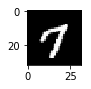

In [68]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [82]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

In [83]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

In [84]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [85]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [86]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [87]:
EPOCHS = 10
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.964

EPOCH 2 ...
Validation Accuracy = 0.980

EPOCH 3 ...
Validation Accuracy = 0.980

EPOCH 4 ...
Validation Accuracy = 0.987

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.987

EPOCH 10 ...
Validation Accuracy = 0.990

Model saved


In [88]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.988


In [79]:
# def LeNet(x):    
#     # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
#     mu = 0
#     sigma = 0.1

#     # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
#     conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
#     conv1_b = tf.Variable(tf.zeros(6))
#     conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

#     # SOLUTION: Activation.
#     conv1 = tf.nn.relu(conv1)


#     # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
#     conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

#     # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
#     conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
#     conv2_b = tf.Variable(tf.zeros(16))
#     conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

#     # SOLUTION: Activation.
#     conv2 = tf.nn.relu(conv2)



#     # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
#     conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

#     # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
#     fc0   = flatten(conv2)

#     # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
#     fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
#     fc1_b = tf.Variable(tf.zeros(120))
#     fc1   = tf.matmul(fc0, fc1_W) + fc1_b

#     # SOLUTION: Activation.
#     fc1    = tf.nn.relu(fc1)
#     fc1    = tf.nn.dropout(fc1,0.6)

#     # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
#     fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
#     fc2_b  = tf.Variable(tf.zeros(84))
#     fc2    = tf.matmul(fc1, fc2_W) + fc2_b

#     # SOLUTION: Activation.
#     fc2    = tf.nn.relu(fc2)
#     fc2    = tf.nn.dropout(fc2,0.7)


#     # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
#     fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev =        sigma))
#     fc3_b  = tf.Variable(tf.zeros(43))

#     logits = tf.matmul(fc2, fc3_W) + fc3_b

#     return logits

---
# 11. Implement AlexNet
In the last section, you should implement **AlexNet** either using Tensorflow or Keras. Again, please take a look at its [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) before start to implement it.
The AlexNet CNN architecture won the [ImageNet ILSVRC challenge](http://www.image-net.org/challenges/LSVRC/2012/) in 2012 by a large margin. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The following table presents this architecture.
<img src="figs/20-alexnet.png" style="width: 600px;"/>
To train the model, we need a big dataset, however, in this assignment you are going to to assign the pretrained weights to your model, using `tf.Variable.assign`. You can download the pretrained weights from [bvlc_alexnet.npy](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy). This file is a NumPy array file created by the python. After you read this file, you will receive a python dictionary with a <key, value> pair for each layer. Each key is one of the layers names, e.g., `conv1`, and each value is a list of two values: (1) weights, and (2) biases of that layer. Part of the function to load the weights and biases to your model is given, and you need to complete it.

Here is what you see if you read and print the shape of each layer from the file:
```
weight_dic = np.load("bvlc_alexnet.npy", encoding="bytes").item()
for layer in weights_dic:
    print("-" * 20)
    print(layer)
    for wb in weights_dic[layer]:
        print(wb.shape)

#--------------------
# fc8
# (4096, 1000) # weights
# (1000,) # bias
#--------------------
# fc7
# (4096, 4096) # weights
# (4096,) # bias
#--------------------
# fc6
# (9216, 4096) # weights
# (4096,) # bias
#--------------------
# conv5
# (3, 3, 192, 256) # weights
# (256,) # bias
#--------------------
# conv4
# (3, 3, 192, 384) # weights
# (384,) # bias
#--------------------
# conv3
# (3, 3, 256, 384) # weights
# (384,) # bias
#--------------------
# conv2
# (5, 5, 48, 256) # weights
# (256,) # bias
#--------------------
# conv1
# (11, 11, 3, 96) # weights
# (96,) # bias
```


In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# to reset the Tensorflow default graph
reset_graph()

# build the AlexNet model
<FILL IN> :)

# load inital weights and biases to the model
def load_initial_weights(self, session):
    # load the weights into memory
    weights_dic = np.load('bvlc_alexnet.npy', encoding='bytes').item()

    # loop over all layer names stored in the weights dict
    for layer in weights_dict:
        with tf.variable_scope(layer, reuse=True):
            # loop over list of weights/biases and assign them to their corresponding tf variable
            for wb in weights_dict[layer]:
                # biases
                if len(wb.shape) == 1:
                    bias = tf.get_variable(<FILL IN>)
                    session.run(bias.assign(wb))
                # weights
                else:
                    weight = tf.get_variable(<FILL IN>)
                    session.run(weight.assign(wb))
                

#### Test the model
After building the AlexNet model, you can test it on different images and present the accuracy of the model. To do so, first you need to use **OpenCV** library to make the images ready to give as input to the model. OpenCV is a library used for image processing. Below you can see how to read an image file and pre-process it using OpenCV to give it to the model. However, you need to complete the code and test the accuracy of your model. The teset images (shown below) are available in the `test_images` folder.
<table width="100%">
<tr>
<td><img src="test_images/test_image1.jpg" style="width:200px;"></td>
<td><p align="center"><img src="test_images/test_image2.jpg" style="width:200px;"></td>
<td align="right"><img src="test_images/test_image3.jpg" style="width:200px;"></td>
</tr>

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
# test the AlexNet model on the given images

import cv2

#get list of all images
current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'test_images')
img_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))

with tf.Session() as sess:
    <FILL IN>
    
    # loop over all images
    for i, image in enumerate(imgs):
        # convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227, 227))
        
        # subtract the ImageNet mean
        # Mean subtraction per channel was used to center the data around zero mean for each channel (R, G, B).
        # This typically helps the network to learn faster since gradients act uniformly for each channel.
        imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
        img -= imagenet_mean
        
        # reshape as needed to feed into model
        img = img.reshape((1, 227, 227, 3))
        
        <FILL IN>